# EQS GB Cross-Validation for Simple sources

Using cross-validation to determine the best damping and depth for the model.

In [1]:
import warnings
import itertools
import numpy as np
import verde as vd
import pandas as pd
import xarray as xr
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import eqs_magnetics as eqs
import synthetics

In [2]:
# Suppress some scikit-learn warning that isn't valid
warnings.filterwarnings("ignore", category=RuntimeWarning)

Set the data coordinates and field direction.

N data: 92046


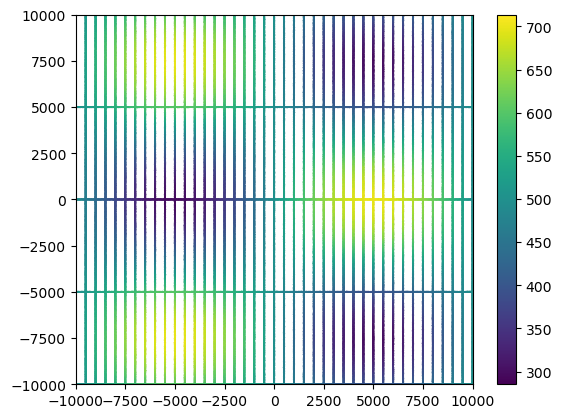

In [3]:
region = [-10e3, 10e3, -10e3, 10e3]
# Inc and dec from the IGRF around Antarctica
field_direction = eqs.angles_to_vector(inclination=84, declination=120, amplitude=1)
#field_direction = eqs.angles_to_vector(inclination=14, declination=122, amplitude=1)

# Generate fake flight lines
easting, northing = [c.ravel() for c in vd.grid_coordinates(region, spacing=(10, 500))]
easting_tie, northing_tie = [c.ravel() for c in vd.grid_coordinates(region, spacing=(5000, 10))]
easting = np.concatenate([easting, easting_tie])
northing = np.concatenate([northing, northing_tie])
upward = vd.synthetic.CheckerBoard(region=region, amplitude=200, w_east=20000, w_north=15000).predict((easting, northing)) + 500
coordinates = (easting, northing, upward)
for i, c in enumerate(coordinates):
    eqs.contaminate(c, standard_deviation=5, random_state=i)

print("N data:", coordinates[0].size)

plt.scatter(*coordinates[:2], c=coordinates[2], s=0.1)
plt.xlim(*region[:2])
plt.ylim(*region[2:])
plt.colorbar()
plt.show()

Create the dipole source model.

In [4]:
source_direction = [70, 60] # [inc, dec]
source_coordinates, dipole_moments = synthetics.simple_synthetic(
    dike1=source_direction,
    dike2=source_direction,
    point1=source_direction,
    point2=source_direction,
    point3=source_direction,
    point4=source_direction,
    regional=source_direction,
)

In [5]:
b_field = eqs.dipole_magnetic(coordinates, source_coordinates, dipole_moments)

In [6]:
tfa = eqs.contaminate(
    eqs.total_field_anomaly(b_field, field_direction), standard_deviation=50, random_state=42,
)
bnorm = eqs.magnetic_field_norm(b_field)

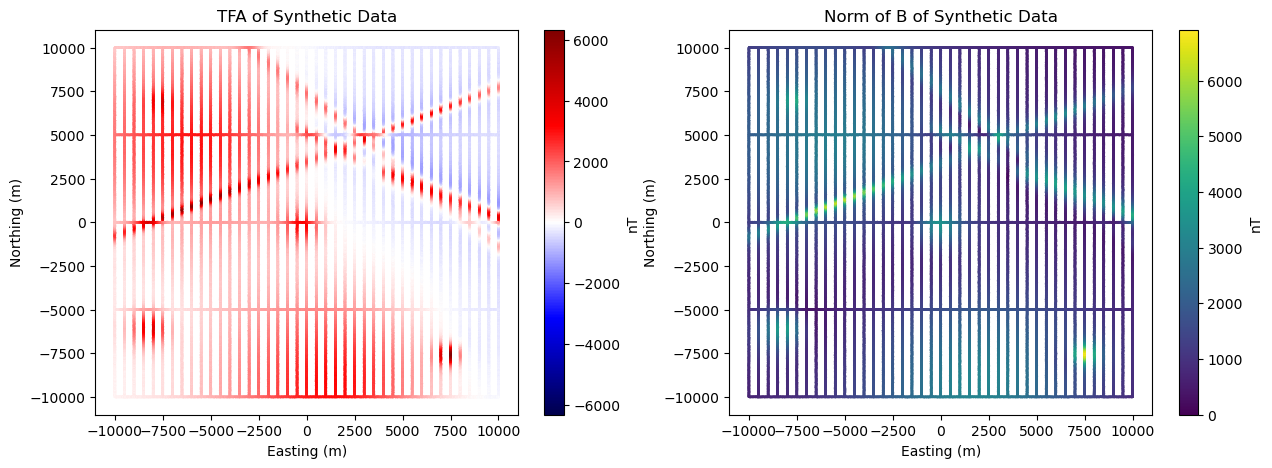

In [7]:
plt.figure(figsize=(15,5))
scale = vd.maxabs(tfa)
#scale = 1000
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa, cmap="seismic", s=0.5, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

scale_bnorm = vd.maxabs(bnorm)
plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=bnorm, cmap="viridis", s=0.5, vmin=0, vmax=scale_bnorm)
plt.title("Norm of B of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit deep sources

Block reduce the data has several advantages:

1. Less data to fit so much faster.
2. The block median reduces the wavelengths in the data, which captures the regional field and leaves the residuals alone.

In [8]:
reducer = vd.BlockReduce(reduction=np.median, spacing=2e3, drop_coords=False)
# Use the filter method to apply the reduction:
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=tfa)

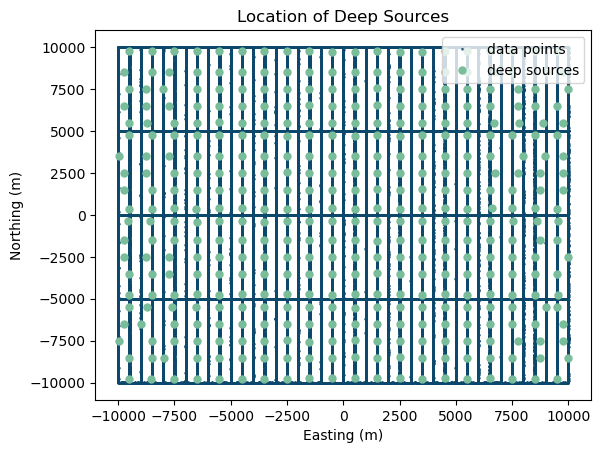

In [9]:
plt.figure()
plt.plot(*coordinates[:2], "v", color="#0B486B", markersize=1, label='data points')
plt.plot(*coords_blocked[:2], "o", color="#79BD9A", markersize=5, label='deep sources')
plt.title("Location of Deep Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.legend()
plt.show()

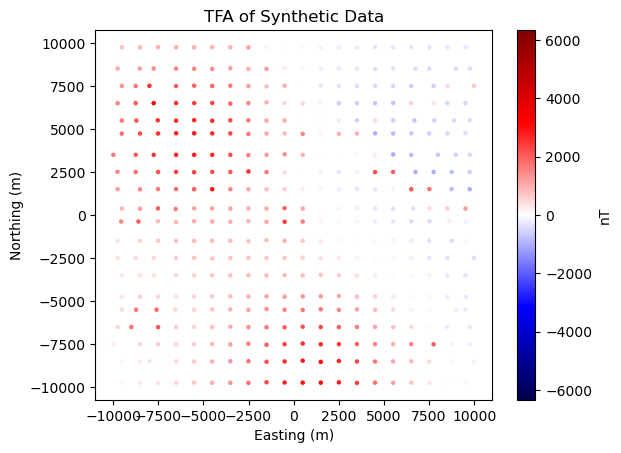

In [10]:
plt.figure()
plt.scatter(*coords_blocked[:2], c=tfa_blocked, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

In [11]:
# %%time
# eqs_deep = eqs.EquivalentSourcesMagnetic(damping=1e-4)
# eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
# print("source height:", eqs_deep.dipole_coordinates_[2][0])

In [12]:
dampings = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e1, 1e2, 1e3, 1e4, 1e5]
spacing = np.mean(vd.median_distance(coords_blocked))
depths = [spacing*2.5, spacing*4.25, spacing*6]
parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]
print("Number of combinations:", len(parameter_sets))
# print("Combinations:", parameter_sets)

Number of combinations: 30


In [13]:
%%time
kfold = vd.BlockKFold(
    spacing=2500,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coords_blocked[:2])
scores = []
for parameters in parameter_sets:    
    print(parameters)
    eqs_deep = eqs.EquivalentSourcesMagnetic(block_size=100, **parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_deep.fit(
            [c[train] for c in coords_blocked], 
            tfa_blocked[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_deep.predict([c[test] for c in coords_blocked]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_blocked[test] - predicted))
    scores.append(np.mean(tmp))
    print(np.mean(tmp))

{'damping': 1e-05, 'depth': 2274.586424914955}
6352.647396875114
{'damping': 1e-05, 'depth': 3866.7969223554232}
6714.899185317778
{'damping': 1e-05, 'depth': 5459.007419795891}
6498.472579753307
{'damping': 0.0001, 'depth': 2274.586424914955}
6352.629682931489
{'damping': 0.0001, 'depth': 3866.7969223554232}
5743.551756056085
{'damping': 0.0001, 'depth': 5459.007419795891}
5829.9560671196705
{'damping': 0.001, 'depth': 2274.586424914955}
6352.453568250863
{'damping': 0.001, 'depth': 3866.7969223554232}
4986.799128893801
{'damping': 0.001, 'depth': 5459.007419795891}
5325.664185861541
{'damping': 0.01, 'depth': 2274.586424914955}
6350.790586339406
{'damping': 0.01, 'depth': 3866.7969223554232}
4562.983138684036
{'damping': 0.01, 'depth': 5459.007419795891}
4504.285517086073
{'damping': 0.1, 'depth': 2274.586424914955}
6340.92395897566
{'damping': 0.1, 'depth': 3866.7969223554232}
4274.024569868289
{'damping': 0.1, 'depth': 5459.007419795891}
3996.796717217504
{'damping': 10.0, 'depth':

In [14]:
best = np.argmin(scores)
parameter_sets[best]

{'damping': 10.0, 'depth': 5459.007419795891}

In [15]:
%%time
eqs_deep = eqs.EquivalentSourcesMagnetic(**parameter_sets[best])
eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
print("source height:", eqs_deep.dipole_coordinates_[2][0])

source height: -4945.574021226482
CPU times: user 1.21 s, sys: 53.6 ms, total: 1.27 s
Wall time: 290 ms


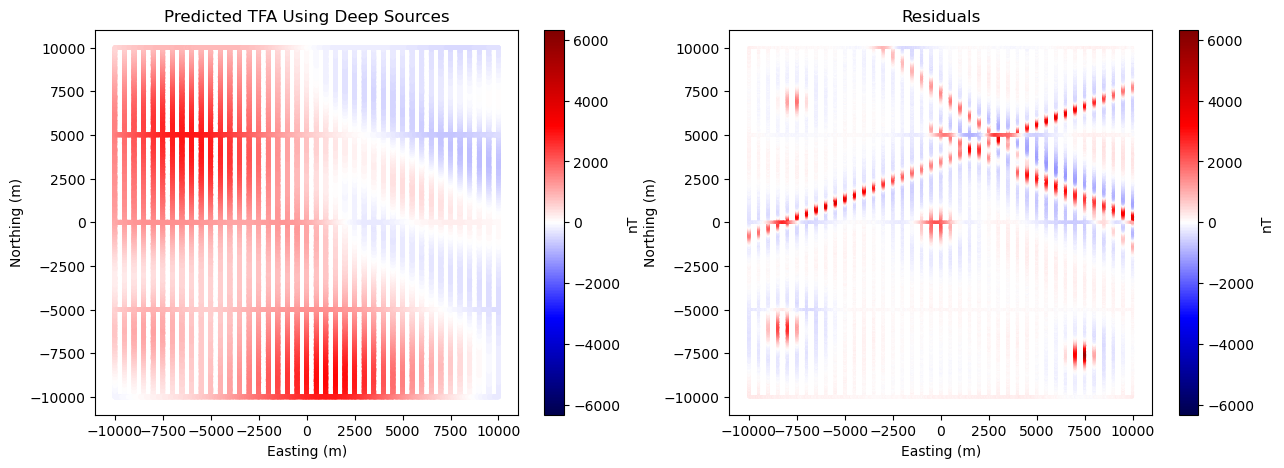

In [16]:
tfa_deep_blocked = eqs.total_field_anomaly(eqs_deep.predict(coords_blocked), field_direction)
tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
tfa_residuals = tfa - tfa_deep

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_deep, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("Predicted TFA Using Deep Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=tfa_residuals, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit the deep residuals with gradient-boosted sources

In [17]:
dampings = [1e-3, 1e-2, 1e-1, 1e1, 1e2]
depths = [600, 700, 800, 900, 1e3]
parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]
print("Number of combinations:", len(parameter_sets))
# print("Combinations:", parameter_sets)

Number of combinations: 25


In [18]:
%%time
kfold = vd.BlockKFold(
    spacing=500,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores = []
for parameters in parameter_sets:    
    print(parameters)
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=100, **parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa_residuals[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_residuals[test] - predicted))
    scores.append(np.mean(tmp))
    print(np.mean(tmp))

{'damping': 0.001, 'depth': 600}
18144.216674362287
{'damping': 0.001, 'depth': 700}
17150.908287064816
{'damping': 0.001, 'depth': 800}
17785.335560353833
{'damping': 0.001, 'depth': 900}
19638.519993345828
{'damping': 0.001, 'depth': 1000.0}
21649.03834796436
{'damping': 0.01, 'depth': 600}
17785.832028076267
{'damping': 0.01, 'depth': 700}
16884.636801557142
{'damping': 0.01, 'depth': 800}
17678.669546470137
{'damping': 0.01, 'depth': 900}
19296.27868875517
{'damping': 0.01, 'depth': 1000.0}
21538.916292285263
{'damping': 0.1, 'depth': 600}
18098.91755251905
{'damping': 0.1, 'depth': 700}
17392.06348612517
{'damping': 0.1, 'depth': 800}
18444.71374102127
{'damping': 0.1, 'depth': 900}
20470.152106625912
{'damping': 0.1, 'depth': 1000.0}
22241.909729592466
{'damping': 10.0, 'depth': 600}
21045.11131949139
{'damping': 10.0, 'depth': 700}
20910.928300109284
{'damping': 10.0, 'depth': 800}
22284.4044796561
{'damping': 10.0, 'depth': 900}
24306.53630319633
{'damping': 10.0, 'depth': 1000

In [19]:
best = np.argmin(scores)
parameter_sets[best]

{'damping': 0.01, 'depth': 700}

In [20]:
%%time
eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=100, **parameter_sets[best])
eqs_shallow.fit(coordinates, tfa_residuals, field_direction)
print("dipole height:", eqs_shallow.dipole_coordinates_[2][0])
print("window size:", eqs_shallow.window_size_)

dipole height: -199.5717779840325
window size: 4669.642453391388
CPU times: user 3min 52s, sys: 1min 2s, total: 4min 54s
Wall time: 11.8 s


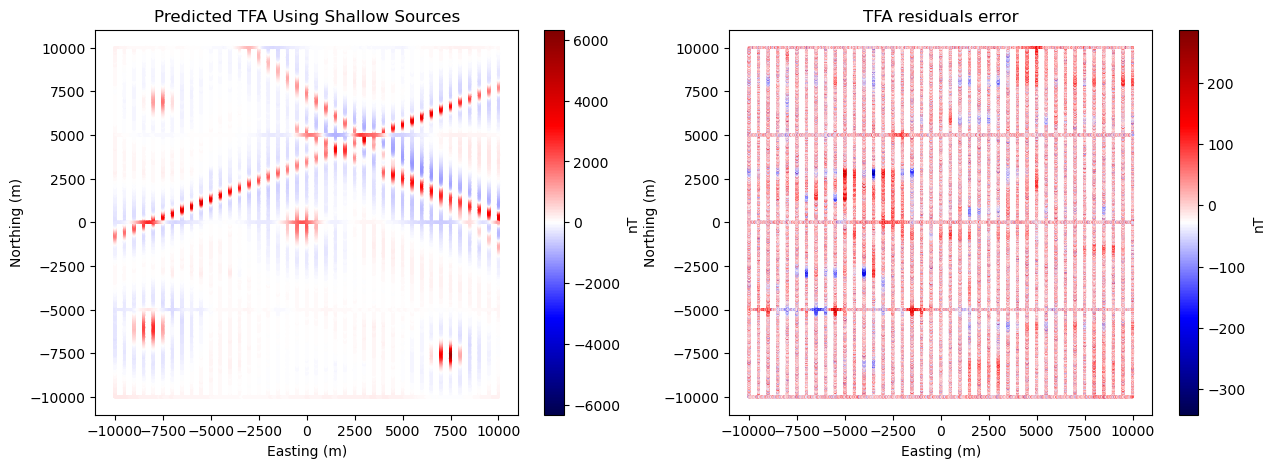

In [21]:
tfa_residuals_prediction = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_residuals_prediction, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Predicted TFA Using Shallow Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=tfa_residuals - tfa_residuals_prediction, cmap="seismic", s=1)
plt.title("TFA residuals error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Predict the norm of B

In [22]:
grid_coordinates = vd.grid_coordinates(region, spacing=100, extra_coords=500)
true_b = eqs.dipole_magnetic(grid_coordinates, source_coordinates, dipole_moments)
predicted_b = eqs_deep.predict(grid_coordinates) + eqs_shallow.predict(grid_coordinates)

true_tfa = eqs.total_field_anomaly(true_b, field_direction)
predicted_tfa = eqs.total_field_anomaly(predicted_b, field_direction)
error_tfa = true_tfa - predicted_tfa

In [23]:
true_norm_of_b = np.sqrt(sum(c**2 for c in true_b))
predicted_norm_of_b = np.sqrt(sum(c**2 for c in predicted_b))
error_norm_of_b = true_norm_of_b - predicted_norm_of_b

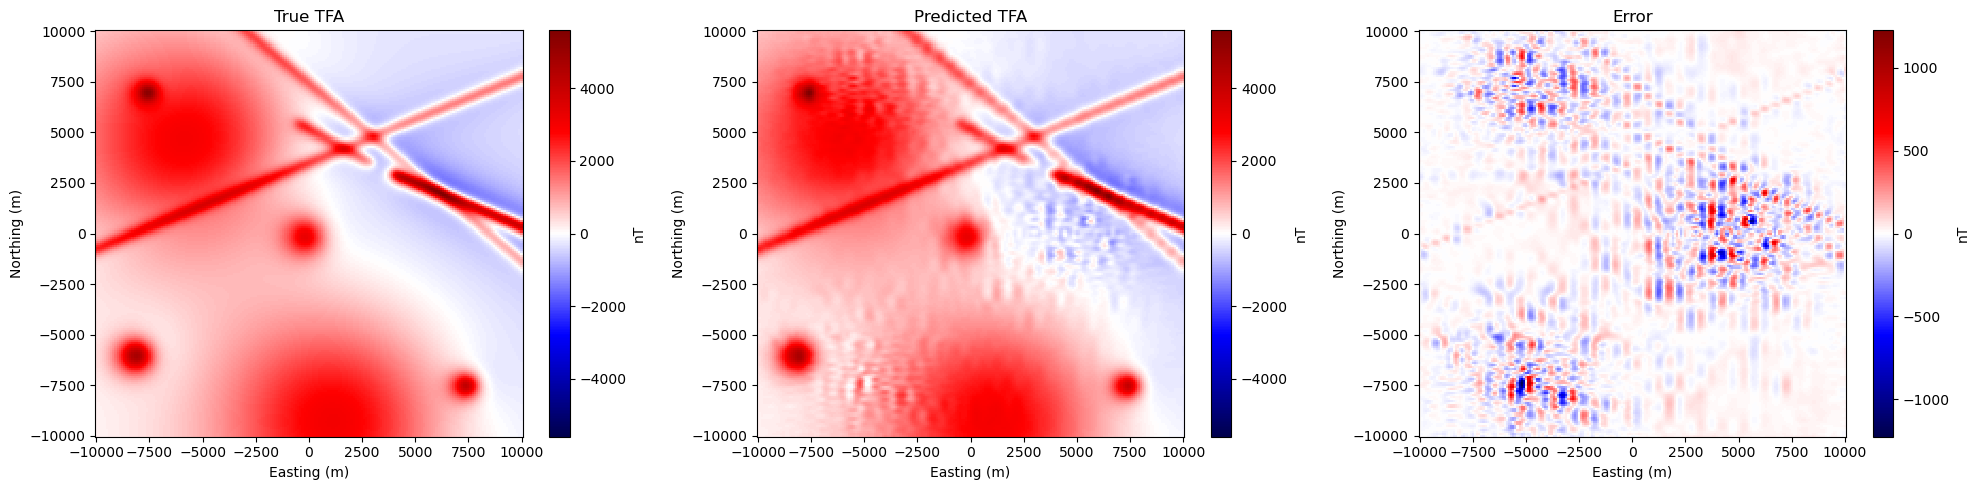

In [24]:
scale_tfa = vd.maxabs(true_tfa)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.pcolormesh(*grid_coordinates[:2], true_tfa, cmap="seismic", vmin=-scale_tfa, vmax=scale_tfa)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
plt.pcolormesh(*grid_coordinates[:2], predicted_tfa, cmap="seismic", vmin=-scale_tfa, vmax=scale_tfa)
plt.title("Predicted TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
diff_scale = vd.maxabs(error_tfa)
plt.pcolormesh(*grid_coordinates[:2], error_tfa, cmap="seismic", vmin=-diff_scale, vmax=diff_scale)
plt.title("Error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()

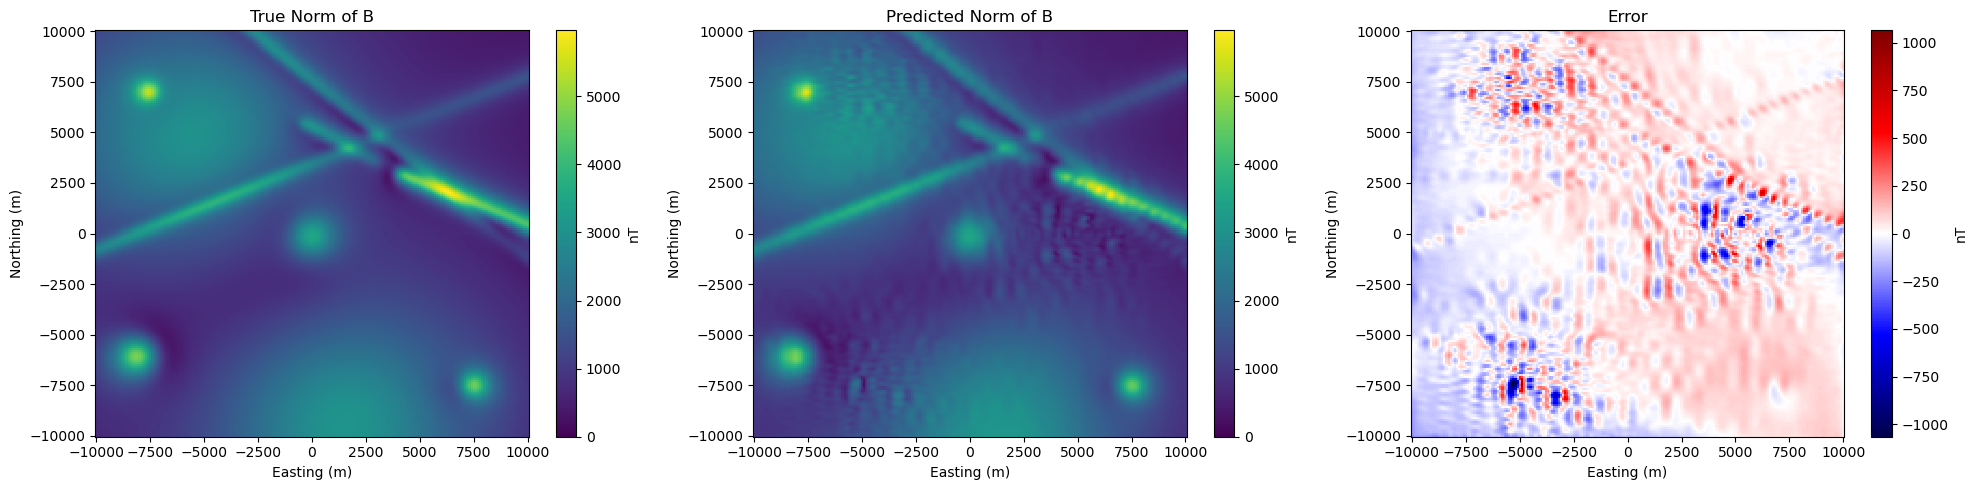

In [25]:
scale_b = vd.maxabs(true_norm_of_b)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.pcolormesh(*grid_coordinates[:2], true_norm_of_b, cmap="viridis", vmin=0, vmax=scale_b)
plt.title("True Norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
plt.pcolormesh(*grid_coordinates[:2], predicted_norm_of_b, cmap="viridis", vmin=0, vmax=scale_b)
plt.title("Predicted Norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
diff_scale = vd.maxabs(error_norm_of_b)
plt.pcolormesh(*grid_coordinates[:2], error_norm_of_b, cmap="seismic", vmin=-diff_scale, vmax=diff_scale)
plt.title("Error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()

## Save data

Save data to pandas dataframe

In [26]:
# simple_synthetic_data = pd.DataFrame(np.transpose(b_field), columns= ['b_easting','b_northing','b_upward'])

In [27]:
# simple_synthetic_data.insert(0, 'easting', np.transpose(coordinates[0]))
# simple_synthetic_data.insert(1, 'northing', np.transpose(coordinates[1]))
# simple_synthetic_data.insert(2, 'upward', np.transpose(coordinates[2]))
# simple_synthetic_data.insert(3, 'observed_tfa', np.transpose(tfa))
# simple_synthetic_data.insert(7, 'bnorm', np.transpose(bnorm))
# simple_synthetic_data.insert(8, 'tfa_deep', np.transpose(tfa_deep))
# simple_synthetic_data.insert(9, 'tfa_deep_residuals', np.transpose(tfa_residuals))
# simple_synthetic_data.insert(10, 'tfa_shallow', np.transpose(tfa_residuals_prediction))
# simple_synthetic_data.insert(11, 'tfa_shallow_residuals', np.transpose(tfa_residuals - tfa_residuals_prediction))

In [28]:
# simple_synthetic_data

In [29]:
# simple_synthetic_sources = pd.DataFrame(np.transpose(source_coordinates), columns= ['easting','northing','upward'])
# simple_synthetic_sources.insert(3, 'dipole_moments_easting', np.transpose(dipole_moments[0]))
# simple_synthetic_sources.insert(4, 'dipole_moments_northing', np.transpose(dipole_moments[1]))
# simple_synthetic_sources.insert(5, 'dipole_moments_upward', np.transpose(dipole_moments[2]))

In [30]:
# simple_synthetic_sources

Save grid to xarray

In [31]:
# simple_synthetic_grid = vd.make_xarray_grid(grid_coordinates, data=(true_norm_of_b, predicted_norm_of_b), data_names=('true_bnorm', 'predicted_bnorm'), dims=('northing', 'easting'), extra_coords_names='upward')
# simple_synthetic_grid

- Save pd df to csv
- Save xarray to netCDF

In [32]:
# simple_synthetic_data.to_csv('simple_synthetic_data.csv', index=False)
# simple_synthetic_sources.to_csv('simple_synthetic_sources.csv', index=False)
# simple_synthetic_grid.to_netcdf('simple_synthetic_grid.nc')